In [1]:
import numpy as np
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt 
import random

### Notes and methods from Kyle Douglas: http://kmdouglass.github.io/posts/modeling-noise-for-image-simulations/

In [2]:
import numpy as np
#import uncertainties.unumpy as unp


def center():
    return [2, 3] # or the arg-number of the center.


def args():
    return 'amp', 'x0', 'y0', 'sig_x', 'sig_y', 'theta', 'offset'


def f(coordinates, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    """
    The normal function call for this function. Performs checks on valid arguments, then calls the "raw" function.
    :return:
    """
    if sigma_x > 50 or sigma_y > 50:
        #print('!',end='')
        return 1e10*np.ones(len(coordinates[0])*len(coordinates[0][0]))
    # limit the angle to a small range to prevent unncecessary flips of the axes. The 2D gaussian has two axes of
    # symmetry, so only a quarter of the 2pi is needed.
    if theta > np.pi/4 or theta < -np.pi/4:
        return 1e10*np.ones(len(coordinates[0])*len(coordinates[0][0]))
    res = f_raw(coordinates, amplitude, xo, yo, sigma_x, sigma_y, theta, offset)
    #print('{0: 3.16f}   {1: 3.16f}   {2: 3.16f}   {3: 3.16f}   {4: 3.16f}   {5: 3.16f}   {6: 3.16f}'.format(amplitude, xo, yo, sigma_x, sigma_y, theta, offset))
    return res

def f_notheta(coordinates, amplitude, xo, yo, sigma_x, sigma_y, offset):
    return f(coordinates, amplitude, xo, yo, sigma_x, sigma_y, 0, offset)


def f_noravel(coordinates, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    #if sigma_x > 1 or sigma_y > 1:
    #    return 1e10

    x = coordinates[0]
    y = coordinates[1]
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp(- (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g


def f_raw(coordinates, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    """
    The raw function call, performs no checks on valid parameters..
    :return:
    """
    return f_noravel(coordinates, amplitude, xo, yo, sigma_x, sigma_y, theta, offset).ravel()


def f_unc(coordinates, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    """
    similar to the raw function call, but uses unp instead of np for uncertainties calculations.
    :return:
    """
    x = coordinates[0]
    y = coordinates[1]
    xo = float(xo)
    yo = float(yo)
    a = (unp.cos(theta)**2)/(2*sigma_x**2) + (unp.sin(theta)**2)/(2*sigma_y**2)
    b = -(unp.sin(2*theta))/(4*sigma_x**2) + (unp.sin(2*theta))/(4*sigma_y**2)
    c = (unp.sin(theta)**2)/(2*sigma_x**2) + (unp.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*unp.exp(- (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()


def areaUnder(amplitude, sigma_x, sigma_y):
    return amplitude * sigma_x * np.sqrt(2 * np.pi) * sigma_y * np.sqrt(2 * np.pi)


def guess(key, values):
    """
    Returns guess values for the parameters of this function class based on the input. Used for fitting using this
    class.
    :param key:
    :param values:
    :return:
    """

### Beginning with a "blank-slate." Layer noise effects later.

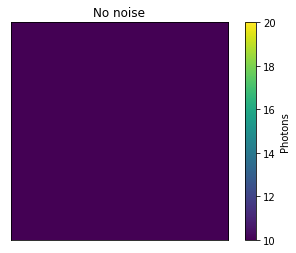

In [3]:
num_photons = 2
num_pixels  = 512
mu_p        = num_photons * np.ones((num_pixels, num_pixels))

fig, ax = plt.subplots()
img = ax.imshow(mu_p, vmin=10, vmax=20)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('No noise')

cb = plt.colorbar(img)
cb.set_label('Photons')

plt.show()

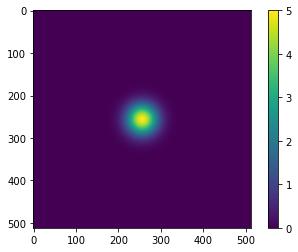

In [4]:
def gaus(x, a, m, s):
    return np.sqrt(a)*np.exp(-(x-m)**2/(2*s**2))
    # if you want it normalized:
    #return 1/(np.sqrt(2*np.pi*s**2))*np.exp(-(x-m)**2/(2*s**2))                               

xx, yy = np.meshgrid(np.arange(512), np.arange(512))
gaus2d = gaus(xx, 5, 256, 25)*gaus(yy, 5, 256, 25)

plt.figure()
plt.imshow(gaus2d) 
plt.colorbar()

### Now we add shot noise with a poissonian distribution.

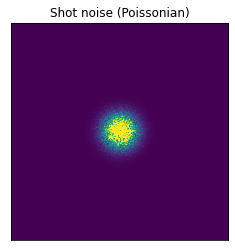

In [5]:
seed       = 42
rs         = np.random.RandomState(seed)
shot_noise = 1.41*rs.poisson(num_photons, (num_pixels, num_pixels))*gaus2d

fig, ax0= plt.subplots(ncols=1)
img0 = ax0.imshow(shot_noise, vmin=0, vmax=10)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_title('Shot noise (Poissonian)')

#divider = make_axes_locatable(ax0)
#cax = divider.append_axes("right", size="5%", pad=0.05)
#cb1 = plt.colorbar(img0)
#cb1.set_label('Photons')

plt.show()

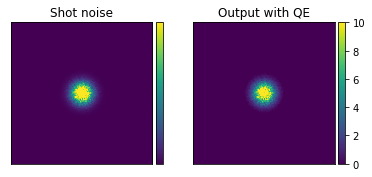

In [6]:
quantum_efficiency = 0.90
electrons = np.round(quantum_efficiency * shot_noise)

fig, (ax0, ax1) = plt.subplots(ncols=2)
img0 = ax0.imshow(shot_noise, vmin=0, vmax=10)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_title('Shot noise')

divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb0 = plt.colorbar(img0, cax=cax)
cb0.set_ticks([])

img1 = ax1.imshow(electrons, vmin=0, vmax=10)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Output with QE')

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(img1, cax=cax)

plt.show()

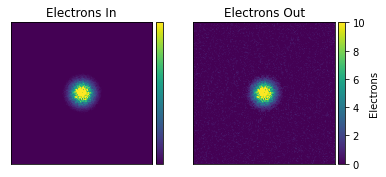

In [7]:
dark_noise = 1
electrons_out = np.round(rs.normal(scale=dark_noise, size=electrons.shape) + electrons)

fig, (ax0, ax1) = plt.subplots(ncols=2)
img0 = ax0.imshow(electrons, vmin=0, vmax=10)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_title('Electrons In')

divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb0 = plt.colorbar(img0, cax=cax)
cb0.set_ticks([])

img1 = ax1.imshow(electrons_out, vmin=0, vmax=10)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Electrons Out')

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(img1, cax=cax)
cb.set_label('Electrons')

plt.show()

### Now adding the EM gain noise

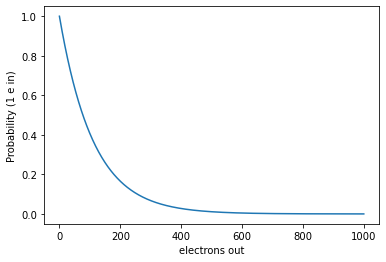

In [8]:
x = np.arange(1000)

def gain(x): 
    return np.exp(-0.009*x)

plt.figure()
plt.plot(x, gain(x))
plt.xlabel("electrons out")
plt.ylabel("Probability (1 e in)")
plt.show()


In [9]:
gain = gain(x)

In [10]:
Gained = random.choice(list(enumerate(gain)))
print(Gained[0])

735


In [11]:
from scipy.ndimage.filters import gaussian_filter

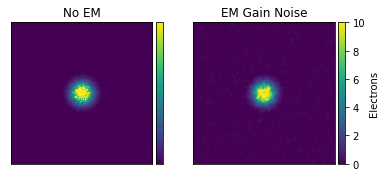

In [13]:
ElectronsGained = np.round(rs.normal(scale=electrons, size=electrons.shape) + electrons_out)
blur = gaussian_filter(ElectronsGained, sigma=3)

fig, (ax0, ax1) = plt.subplots(ncols=2)
img0 = ax0.imshow(electrons, vmin=0, vmax=10)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_title('No EM')

divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb0 = plt.colorbar(img0, cax=cax)
cb0.set_ticks([])

img1 = ax1.imshow(blur, vmin=0, vmax=10)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('EM Gain Noise')

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(img1, cax=cax)
cb.set_label('Electrons')

plt.show()